# Order by Order analysis of RVs of GL667C created by Wobble
## June 2021


### Package Imports

In [61]:
from datetime import time
import numpy as np
from numpy.core.defchararray import upper
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import arviz as az
import os
import wobble
import exoplanet as xo
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

In [65]:
def load_results(results_txt, results_hdf5):
    results = results_txt
    results = pd.read_csv(results, skiprows=3, delim_whitespace=True)
    results_hdf5 = results_hdf5
    results_hdf5 = wobble.Results(filename = results_hdf5)
    return results, results_hdf5

def plot_rvs(times, rvs, rvs_err, star_name):
    rvs = rvs - np.median(rvs)
    plt.figure()
    plt.errorbar(times, rvs, rvs_err, fmt='.k')
    plt.title('Combined Orders for {}'.format(star_name))
    plt.ylabel('Radial Velocity [ms$^{-1}$]')
    plt.xlabel('MJD')

def straight_line (x, m, c):
    return (m * x) + c

def normalise_rvs(rv_data):
    normalised_rvs = rv_data - np.median(rv_data)
    return normalised_rvs

def linear_fit(times, rvs, rvs_err):
    popt, pcov = curve_fit(straight_line, times, rvs, sigma = rvs_err)
    perr = np.sqrt(np.diag(pcov))
    gradient = popt[0]
    intercept = popt[1]
    gradient_err = perr[0]
    intercept_err = perr[1]
    return np.array([gradient, intercept, gradient_err, intercept_err])

def plot_rvs(times, rvs, rvs_err, star_name):
    # gradient, intercept, gradient_err, intercept_err = linear_fit(times, rvs, rvs_err)
    plt.figure()
    plt.errorbar(times, rvs, rvs_err, fmt='.k')
    # plt.plot(times, straight_line(times, gradient, intercept))
    plt.title('{}'.format(star_name))
    plt.ylabel('Radial Velocity [ms$^{-1}$]')
    plt.xlabel('MJD')

def detrend_rvs(times, rvs, rvs_err):
    gradient, intercept, gradient_err, intercept_err = linear_fit(times, rvs, rvs_err)
    detrended_rvs = [rvs[i] - (straight_line(times, gradient, intercept))[i] for i in range(0, len(times))]
    return detrended_rvs, gradient, gradient_err

def create_rvs_err_array(results, no_of_orders):
    rvs_errs_all_orders = []
    for order in range(no_of_orders):
        order_rvs_err = np.array(results['RV_order{}_err'.format(order)])
        rvs_errs_all_orders.append(order_rvs_err)
    rvs_errs_all_orders = np.array(rvs_errs_all_orders)
    return rvs_errs_all_orders

def nan_to_inf(rvs_err_array):
    nan_boolean = np.isnan(rvs_err_array) #creating a boolean mask for the location of the nans in the array
    rvs_err_array[nan_boolean] = np.inf #using the mask to turn the nans into infs
    return rvs_err_array, nan_boolean

def plot_nan_locations(nan_boolean):
    plt.figure()
    plt.imshow(nan_boolean, cmap='gray_r')
    plt.title('Location of NaN in RV errors')
    plt.xlabel('Epoch')
    plt.ylabel('Order')  
    plt.ylim(0,no_of_orders)

def create_rvs_array(results, no_of_orders):
    rvs_all_orders = []
    for order in range(no_of_orders):
        order_rvs = np.array(results['RV_order{}'.format(order)])
        rvs_all_orders.append(order_rvs)
    rvs_all_orders = np.array(rvs_all_orders)
    return rvs_all_orders

def find_nearest(array, value):
    array = np.array(array)
    idx = ((np.abs(array - value)).argmin())
    return idx

def detrend_order_rvs(times, rvs_array, rvs_err_array, no_of_orders, trend, trend_err):
    detrended_rvs_all_orders = []
    residual_trends = []
    residual_trends_err = []
    for order in range(no_of_orders):
        order_rvs = rvs_array[order, :]
        order_rvs_err = rvs_err_array[order, :]
        order_rvs_detrended = [order_rvs[i] - (straight_line(times, trend, trend_err))[i] for i in range(0, len(times))]
        order_trend, trend_cov = curve_fit(straight_line, times, order_rvs_detrended, sigma = order_rvs_err)
        order_trend_err = np.sqrt(np.diag(trend_cov))
        order_rvs_detrended = normalise_rvs(order_rvs_detrended) #added this in to see if it fixes things.
        detrended_rvs_all_orders.append(order_rvs_detrended)
        residual_trends.append(order_trend[0])
        residual_trends_err.append(order_trend_err[0])
    detrended_rvs_all_orders = np.array(detrended_rvs_all_orders)
    residual_trends = np.array(residual_trends)
    residual_trends_err = np.array(residual_trends_err)

    return detrended_rvs_all_orders, residual_trends, residual_trends_err

def sine_wave(x_data, amplitude, phase_shift):
    return amplitude * (np.sin((2 * np.pi) * (x_data + phase_shift)))

def subtract_periodic_signal(period, times, rvs, rvs_err):
    phase_folded = (times / period) % 1
    popt, pcov = curve_fit(sine_wave, phase_folded, rvs, sigma = rvs_err)
    signal_subtracted = rvs - sine_wave(phase_folded, popt[0], popt[1])

    return signal_subtracted

def lsp_snr_at_period(times, rvs, rvs_err):
    frequency, power = LombScargle(times, rvs, rvs_err).autopower() #assigning the frequency and power from the lsp
    period = 1 / frequency #turning frequency into period
    noise_b = np.std(power[(period > (lit_period_b-0.1*lit_period_b)) & (period < (lit_period_b + 0.1*lit_period_b))])
    noise_c = np.std(power[(period > (lit_period_c-0.1*lit_period_c)) & (period < (lit_period_c + 0.1*lit_period_c))])
    snr_b = power / noise_b
    snr_c = power / noise_c
    snr_at_b = snr_b[find_nearest(power, lit_period_b)]
    snr_at_c = snr_c[find_nearest(power, lit_period_c)]

    return snr_at_b, snr_at_c

def assign_wavelengths(data, no_of_orders):

    wavelengths = []
    wavelengths_err = []

    for order in range(no_of_orders):
        order_wl = (np.exp(np.mean(data.xs[order][0]))/10)
        order_wl_err = (np.exp(np.std(data.xs[order][0]))/10)
        wavelengths.append(order_wl)
        wavelengths_err.append(order_wl_err)

    wavelengths = np.array(wavelengths)
    wavelengths_err = np.array(wavelengths_err)

    return wavelengths, wavelengths_err

def load_data(data_filename, good_epochs, bad_orders):
    data = wobble.Data(filename=data_filename, epochs=good_epochs)
    data.delete_orders(bad_orders) #deletes the bad orders that have been identified in the 'bad orders' list above.
    data.drop_bad_orders(min_snr=3) #dropping bad orders
    data.drop_bad_epochs(min_snr=3) #dropping bad epochs

    return data

def count_orders(data):
    
    no_of_orders = len(data.orders)

    return no_of_orders

def create_combined_orders(results):
    combined_order_rvs = np.array(results['RV'])
    combined_order_rvs = normalise_rvs(combined_order_rvs)
    combined_order_rvs_err = np.array(results['RV_err'])

    return combined_order_rvs, combined_order_rvs_err

In [3]:
results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr20.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')

Results: reading from /home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5


In [4]:
good_epochs = [ 0,  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176]

bad_orders = np.array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True,  True,  True])

In [5]:
data = load_data('/home/z5345592/projects/gl667c_wobble/data/gl667c.hdf5', good_epochs, bad_orders)

Data: Dropping orders [0 1 2 3 4 5] because they have average SNR < 3


In [6]:
no_of_orders = count_orders(data)

In [7]:
wavelengths, wavelengths_err = assign_wavelengths(data, no_of_orders)

In [8]:
times = np.array(data.dates) #reassigning dates to times so (I think) the PYMC3 code works better later
star_name = 'GL667c (via wobble)' #to differentiate from the pipelines generated by the HARPS pipeline.

lit_period_b = 7.2
lit_period_c = 28.1

lit_amplitude_b = 3.9
lit_amplitude_c = 1.7

In [9]:
combined_order_rvs, combined_order_rvs_err = create_combined_orders(results)

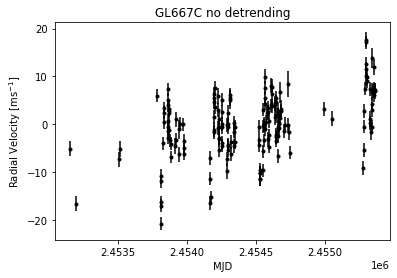

In [10]:
plot_rvs(times, combined_order_rvs, combined_order_rvs_err, 'GL667C no detrending')

In [11]:
rvs_all_orders = create_rvs_array(results, no_of_orders)
rvs_all_orders_err = create_rvs_err_array(results, no_of_orders)
rvs_all_orders_err, rvs_err_nans = nan_to_inf(rvs_all_orders_err)

normalised_rvs = []

for order in range(no_of_orders):
    order_normalised_rvs = normalise_rvs(rvs_all_orders[order, :])
    normalised_rvs.append(order_normalised_rvs)

rvs_all_orders = np.array(normalised_rvs)

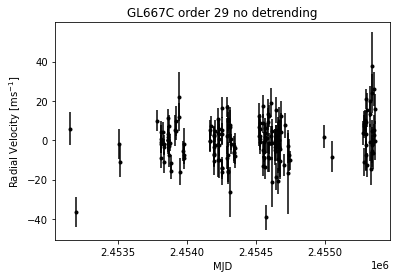

In [12]:
plot_rvs(times, rvs_all_orders[29,:], rvs_all_orders_err[29,:], 'GL667C order 29 no detrending')

In [13]:
detrended_rvs_combined, combined_rvs_trend, combined_rvs_trend_err = detrend_rvs(times, combined_order_rvs, combined_order_rvs_err)

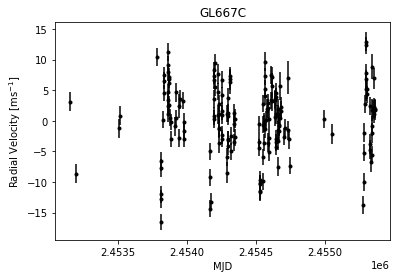

In [14]:
plot_rvs(times, detrended_rvs_combined, combined_order_rvs_err, 'GL667C')

## Order by Order
### Identifying the orders / epochs that have NaN in the RV errors

I noticed that some of the RV errors had NaN in, which made fitting for the trend in each difficult. I need to identify the orders and the epochs that these come from, to be able to do further analysis.

Below I create an order by epoch boolean array where if the value of RV_err is NaN the element in the array is True.

### Replacing the NaN values in the order by order RV_errs with np.inf in order to be able to fit the trend properly.

to do this going to slice each order of rvs_err with the boolean mask I created before and assign it to np.inf.

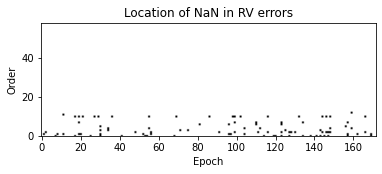

In [15]:
plot_nan_locations(rvs_err_nans)

In [16]:
detrended_rvs_all_orders, residual_trends, residual_trends_err = detrend_order_rvs(times, rvs_all_orders, rvs_all_orders_err, no_of_orders, combined_rvs_trend, combined_rvs_trend_err)

# Subtracting Sine Wave

In [17]:
rvs_planet_b_removed = subtract_periodic_signal(lit_period_b, times, detrended_rvs_combined, combined_order_rvs_err)
rvs_planet_c_removed = subtract_periodic_signal(lit_period_c, times, detrended_rvs_combined, combined_order_rvs_err)

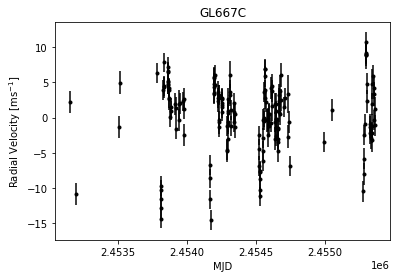

In [18]:
plot_rvs(times, rvs_planet_b_removed, combined_order_rvs_err, 'GL667C')

(0.0, 0.3)

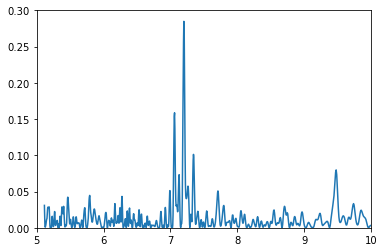

In [19]:
frequency, power = LombScargle(times, rvs_planet_c_removed, combined_order_rvs_err).autopower()
period = 1 / frequency
plt.plot(period, power)
plt.xlim(5,10)
plt.ylim(0,0.3)

In [20]:
snr_at_b_all_orders = []
snr_at_c_all_orders = []

for order in range(no_of_orders):
    rvs_planet_b_removed = subtract_periodic_signal(lit_period_b, times, detrended_rvs_all_orders[order,:], rvs_all_orders_err[order,:])
    rvs_planet_c_removed = subtract_periodic_signal(lit_period_c, times, detrended_rvs_all_orders[order,:], rvs_all_orders_err[order,:])
    snr_at_b_no_c, snr_at_c_no_c = lsp_snr_at_period(times, rvs_planet_c_removed, rvs_all_orders_err[order,:])
    snr_at_b_no_b, snr_at_c_no_b = lsp_snr_at_period(times, rvs_planet_b_removed, rvs_all_orders_err[order,:])
    snr_at_b_all_orders.append(snr_at_b_no_c)
    snr_at_c_all_orders.append(snr_at_c_no_b)

snr_at_b_all_orders = np.array(snr_at_b_all_orders)
snr_at_c_all_orders = np.array(snr_at_c_all_orders)

# Testing 1 order from start to finish to see if it works

In [24]:
n = 29 #choosing order in middle
test_rvs = detrended_rvs_all_orders[n,:]
test_rvs_err = rvs_all_orders_err[n,:]

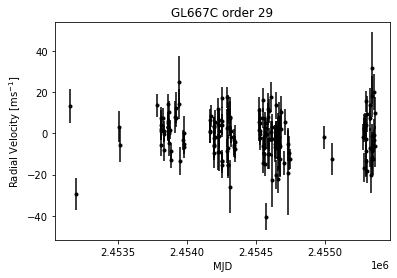

In [25]:
plot_rvs(times, test_rvs, test_rvs_err, 'GL667C order {}'.format(n))

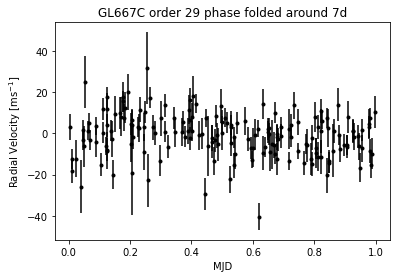

In [26]:
phase_folded = (times / lit_period_b) % 1
plot_rvs(phase_folded, test_rvs, test_rvs_err, 'GL667C order {} phase folded around 7d'.format(n))

(-30.0, 30.0)

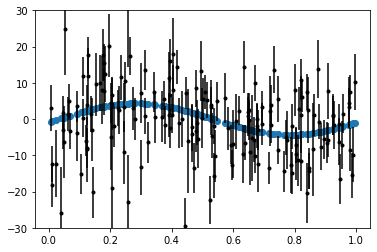

In [40]:
popt, pcov = curve_fit(sine_wave, phase_folded, test_rvs, sigma = test_rvs_err)
plt.figure()
plt.errorbar(phase_folded, test_rvs, test_rvs_err, fmt='.k')
plt.scatter(phase_folded, sine_wave(phase_folded,popt[0], popt[1]))
plt.ylim(-30,30)

In [36]:
test_planet_b_removed = test_rvs - sine_wave(phase_folded,popt[0], popt[1])

## testing the function to see if it produces same as test_planet_b_removed above

In [63]:
test_planet_b_removed == subtract_periodic_signal(lit_period_b, times, test_rvs, test_rvs_err)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [66]:
test_snr_at_b, test_snr_at_c = lsp_snr_at_period(times, test_rvs, test_rvs_err)

In [67]:
test_snr_at_b

6.69343596946121

this number is much too high - when I did it manually the max snr was 7

6.69343596946121


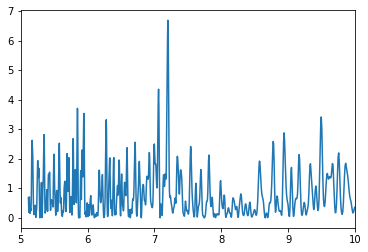

In [60]:
frequency, power = LombScargle(times, test_rvs, test_rvs_err).autopower() #assigning the frequency and power from the lsp
period = 1 / frequency #turning frequency into period
noise_b = np.std(power[(period > (lit_period_b-0.1*lit_period_b)) & (period < (lit_period_b + 0.1*lit_period_b))])
snr_b = power / noise_b
snr_at_b = snr_b[find_nearest(power, lit_period_b)]

plt.plot(period, snr_b)
plt.xlim(5,10)

print(snr_at_b)

In [69]:
import matplotlib.cm as cm
colours = cm.rainbow(np.linspace(0,1,6))
